In [ ]:
#@title Install
!pip install transformers
! pip install git+https://github.com/openai/CLIP.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-xi06jspz
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-xi06jspz
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=6ee17ae0b7c8fddbd3a80151072add11841d93d262eb68f1f4b1e9980a139208
  Sto

In [ ]:
#@title Drive Downloader

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

download_with_pydrive = True #@param {type:"boolean"}  

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()
        
    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)
    
    def download_file(self, file_id, file_dst):
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)

In [ ]:
#@title Imports

import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
from google.colab import files
import skimage.io as io
import PIL.Image
from IPython.display import Image 


N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
os.makedirs(save_path, exist_ok=True)
model_path = os.path.join(save_path, 'model_wieghts.pt')


In [ ]:
#@title Model

class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [ ]:
#@title Caption prediction

def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [ ]:
#@title Choose pretrained model - COCO or Coneptual captions


pretrained_model = 'COCO'  # @param ['COCO', 'Conceptual captions']

if pretrained_model == 'Conceptual captions':
  downloader.download_file("14pXWwB4Zm82rsDdvbGguLfx9F8aM7ovT", model_path)
else:
  downloader.download_file("1IdaBtMSvtyzF0ByVaBHtvM0JYSXRExRX", model_path)

In [ ]:
#@title GPU/CPU


is_gpu = True #@param {type:"boolean"}  


In [ ]:
#@title CLIP model + GPT2 tokenizer

device = CUDA(0) if is_gpu else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 119MiB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Load model weights


prefix_length = 10

model = ClipCaptionModel(prefix_length)

model.load_state_dict(torch.load(model_path, map_location=CPU)) 

model = model.eval() 
device = CUDA(0) if is_gpu else "cpu"
model = model.to(device)


In [ ]:
#@title Upload Image


uploaded = files.upload()

if not uploaded:
  UPLOADED_FILE = ''
elif len(uploaded) == 1:
  UPLOADED_FILE = list(uploaded.keys())[0]
else:
  raise AssertionError('Please upload one image at a time')

print(UPLOADED_FILE)

Saving 55470226_52ff517151.jpg to 55470226_52ff517151.jpg
55470226_52ff517151.jpg


In [ ]:
#@title Or download random samples form COCO test set (Karpathy et al. split)

IMAGE_NAME = '354533'  # @param ['562207', '579664', '060623', '165547', '334321', '483108', '386164', '354533']

name_ = "COCO_val2014_000000" + IMAGE_NAME + ".jpg"
images_path = os.path.join(os.path.dirname(current_directory), "images")
os.makedirs(images_path, exist_ok=True)
UPLOADED_FILE = os.path.join(images_path, name_)

if not os.path.isfile(UPLOADED_FILE):
  download_path = os.path.join(images_path, "images.zip")
  downloader.download_file("1BwJeBME-dpwcCT8IXYeWz7uaPkbexjNB", download_path)

  !unzip {download_path} -d {images_path}



Conceptual captions examples:
https://drive.google.com/file/d/1mzH3b0LQrGEWjEva4hI6HE_fIYRIgtBT/view?usp=sharing

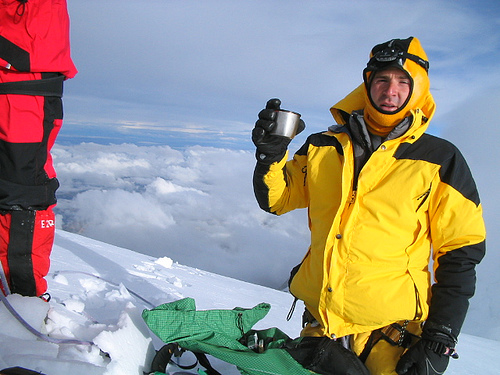

100%|██████████| 1/1 [00:00<00:00,  4.01it/s]



person, the first person to reach the summit.


In [ ]:
#@title Inference
use_beam_search = False #@param {type:"boolean"}  

image = io.imread(UPLOADED_FILE)
pil_image = PIL.Image.fromarray(image)
#pil_img = Image(filename=UPLOADED_FILE)
display(pil_image)

image = preprocess(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    # if type(model) is ClipCaptionE2E:
    #     prefix_embed = model.forward_image(image)
    # else:
    prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
if use_beam_search:
    generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed)[0]
else:
    generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)


print('\n')
print(generated_text_prefix)